In [1]:
import numpy as np
import math
import sympy as sym
from sympy.functions.elementary.trigonometric import atan2
from scipy.integrate import ode
from sympy.utilities.lambdify import lambdify
import Kep_2_Cart
import Cart_2_Kep
import filter_functions
from IPython.core.debugger import Tracer
import warnings
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 4.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display


## Structure of arrays in Output File

### 'measurement_array': measurement_array:
time (s), station (int), Object ID (int), measurements (2 to 3 depending on measType) (az: rad, el: rad, range:m,                                                                                                      range rate: m/s)

### 'true_state': object_eci_pos_vel:
truth only at measurement times
true XYZ pos (m), true XYZ vel (m/s), true density (kg/m**3)

### 'true_state_all_times': true_state_all_times
truth at ALL simulation times
time (s), Object ID (int), true XYZ pos (m), true XYZ vel (m/s), true density (kg/m**3)

### 'lat_lst_array': lat_lst_array_final:
truth only at measurement times
latitude (radians), LST (radians)

In [2]:

r_earth_const = 6378136.3 #meters

circumference = 2 * math.pi * (r_earth_const + 400*1e3)

distance_per_degree = circumference/360

print(distance_per_degree * 1e-3, ' km')

print(distance_per_degree * 9 * 1e-3, ' km')

print(86400/60/6)

118.30079558394611  km
1064.707160255515  km
240.0


In [3]:


class SpaceObject:
    
    def __init__(self, name, ID, area, mass, a, e, i, cap_omega, w, nu):
        
        self.name = name
        self.ID = ID
        self.area = area
        self.mass = mass
        self.a = a
        self.e = e
        self.i = i
        self.cap_omega = cap_omega
        self.w = w
        self.nu = nu

        
class DateSpecs:
    
    def __init__(self, time_span, time_step, year, month, day_of_month_init, day_of_year_init,\
                              hour_init_UT):
        
        self.time_span = time_span
        self.time_step = time_step
        self.year = year
        self.month = month
        self.day_of_month_init = day_of_month_init
        self.day_of_year_init = day_of_year_init
        self.hour_init_UT = hour_init_UT

        
        
class MeasurementSpecs:
    
    def __init__(self, spaceObj, dateObj, measType):
        
        self.spaceObj = spaceObj
        self.dateObj = dateObj
        self.measType = measType



In [4]:

#define constants
r_earth_const = 6378136.3 #meters
omega_const = 7.2921158553e-5
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 #m^3/s^2


#Drag:
C_D_est = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec




In [19]:

with open('Data Files/leo_circ_obj.pkl', 'rb') as f:
    data = pickle.load(f)

print(data)




{'Satellite Name': array(['0 COSMOS 1275 DEB\n', '0 SL-8 R/B\n', '0 CZ-2C DEB\n',
       '0 CZ-4 DEB\n', '0 BREEZE-KM R/B\n', '0 RESURS P2 DEB\n',
       '0 PSLV DEB\n', '0 ISS DEB\n', '0 ISS DEB\n'], dtype=object), 'Arg of Per': array([3.5009053320271177, 1.2306142022886819, 3.5114767913064475,
       5.1559207765477488, 3.5008529721495583, 2.1732455873397951,
       5.1652338534363906, 0.78112734271781814, 5.0385927629116818], dtype=object), 'Satellite ID': array(['13465', '25723', '28225', '29213', '39454', '41541', '42797',
       '43203', '43498'], dtype=object), 'RAAN': array([1.6822338542054827, 1.5572822423967045, 0.27373220389503466,
       0.48524341995647147, 1.211118874543905, 1.7446817348418397,
       0.88810031790180266, 1.6704755710347969, 0.035489525010052696], dtype=object), 'inclination': array([1.4480263765511114, 0.84501337465781867, 1.7007657602031585,
       1.7220203798339453, 1.5280375054502875, 1.6984671615782818,
       1.7000885724533845, 0.90127929908361182

In [12]:


print(np.max(f107_array_repeated[:312]))
print(np.max(ap_index_array_repeated[:312]))

219.0
250


In [10]:


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~HASDM Objects~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


time_span = 60000 #86400
time_step = 3 * 60 #10
meas_step = 3 * 60 

#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year = 2017
month = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init_local = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init_local + boulder_UT_offset

A_const = 0.9551567 #meters^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite

#leo_circ_obj.pkl other leo debris/R/B, near circ, near 400km
#shay_objects.pkl HASDM objects listed in their paper
HASDM_objs_file = open('Data Files/shay_objects.pkl', 'rb') 
mydict = pickle.load(HASDM_objs_file)
HASDM_objs_file.close()


satellite_IDs = mydict['Satellite ID']
cap_omega_array = mydict['RAAN']
satellite_names = mydict['Satellite Name']
i_array = mydict['inclination']
w_array = mydict['Arg of Per']

#nu_array = np.array([math.radians(0), math.radians(9), math.radians(18), math.radians(27), math.radians(36)])


#data from https://omniweb.gsfc.nasa.gov/form/dx1.html
#for a geomagnetic storm, July 15-16 2000
#hourly averaged data, repeating it to fit in the simulation time
#adding ap = 4s in the beginning and end
#adding f10.7 = 180s in the beginning and end (a value around 130-200 seems to be a nominal value,
#known by looking at F10.7 for nominal days)
'''
ap_index_array = np.array([4, 4, 4, 4, 4, 4, 4, 15, 15, 15, 22, 22, 22, 39, 39, 39, 32, 32, 32, 207, 207, 207, 300, 300, 300, \
                           400, 400, 400, 300, 300, 300, 179, 179, 179, 80, 80, 80, 32, 32, 32, 39, 39, \
                           39, 39, 39, 39, 15, 15, 15, 7, 7, 7, 6, 6, 6, 4, 4, 4, 4, 4])
f107_array = np.array([180, 180, 180, 180, 180, 180, 180, 220.1, 220.1, 220.1, 220.1, 220.1, 220.1, 220.1, 220.1, \
                           220.1, 220.1, 220.1, 220.1, 220.1, 220.1, 220.1, 220.1, 220.1, 220.1, \
                           220.1, 220.1, 220.1, 220.1, 220.1, 220.1, 226.1, 226.1, 226.1, 226.1, \
                           226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 226.1, \
                       226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 226.1, 180, 180, 180, 180, 180])

'''
ap_index_array = np.array([10, 17, 22, 36, 50, 60, 80, 110, 130, 150, 170, 190,\
                           207, 230, 250, 270, 290, 300, \
                           400]) #154
f107_array = np.array([180, 183, 185, 188, 190, 192, 195, 198, 200, 203, 205, 208, 215.1, 218, \
                       219, 220.1, 226.1]) #200

print(len(ap_index_array), len(f107_array))

num_2_repeat = (time_span/time_step)/len(ap_index_array) + 5
print(num_2_repeat)


ap_index_array_repeated = np.repeat(ap_index_array, num_2_repeat)
f107_array_repeated = np.repeat(f107_array, num_2_repeat)
print(f107_array_repeated[:100])


for ii in range(5): #len(satellite_IDs)):
    
    objectID = (ii+1) #ID_array[ii]
    print(ii)

    a = r_earth_const + 400*1e3 # meters
    e = 0
    
    i = i_array[ii]
    cap_omega = cap_omega_array[ii]
    w = w_array[ii] 
    nu = math.radians(0) #nu_array[ii]
    
    object_name = 'obj' + str(objectID)

    

    spaceObj = SpaceObject(object_name, objectID, A_const, m_const, a, e, i, cap_omega, w, nu)
 
    dateObj = DateSpecs(time_span, time_step, year, month, day_of_month_init, day_of_year_init,\
                                     hour_init_UT)


    # meas_type = 1: range and range rate
    # meas_type = 2: azimuth and elevation
    # meas_type = 3: azimuth, elevation, and range
    meas_type = 3

    measObj = MeasurementSpecs(spaceObj, dateObj, meas_type)

    
    generate_measurements(measObj, meas_step)




19 17
22.543859649122805
[ 180.  180.  180.  180.  180.  180.  180.  180.  180.  180.  180.  180.
  180.  180.  180.  180.  180.  180.  180.  180.  180.  180.  183.  183.
  183.  183.  183.  183.  183.  183.  183.  183.  183.  183.  183.  183.
  183.  183.  183.  183.  183.  183.  183.  183.  185.  185.  185.  185.
  185.  185.  185.  185.  185.  185.  185.  185.  185.  185.  185.  185.
  185.  185.  185.  185.  185.  185.  188.  188.  188.  188.  188.  188.
  188.  188.  188.  188.  188.  188.  188.  188.  188.  188.  188.  188.
  188.  188.  188.  188.  190.  190.  190.  190.  190.  190.  190.  190.
  190.  190.  190.  190.]
0
396031.80636
1
395346.662123
2
395176.899338
3
395645.133346
4
394852.863691


In [8]:

time_span = 86400
time_step = 60*3 #10

#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year = 2017
month = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init_local = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init_local + boulder_UT_offset

A_const = 0.9551567 #meters^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite









ID_array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
i_array = np.array([math.radians(30), math.radians(30), math.radians(30), 
                    math.radians(25), math.radians(25),\
                    math.radians(45), math.radians(45), math.radians(45), 
                    math.radians(50), math.radians(50),\
                   math.radians(15), math.radians(15), math.radians(15), 
                    math.radians(20), math.radians(20),
                   math.radians(35), math.radians(35), math.radians(35), 
                    math.radians(40), math.radians(40)])
cap_omega_array = np.array([math.radians(30), math.radians(30), math.radians(30), math.radians(30), math.radians(30),\
                            math.radians(30), math.radians(30), math.radians(30), math.radians(30), math.radians(30),\
                           math.radians(30), math.radians(30), math.radians(30), math.radians(30), math.radians(30),\
                           math.radians(30), math.radians(30), math.radians(30), math.radians(30), math.radians(30)])
w_array = np.array([math.radians(0), math.radians(0), math.radians(0), math.radians(0), math.radians(0),
                   math.radians(0), math.radians(0), math.radians(0), math.radians(0), math.radians(0),\
                   math.radians(0), math.radians(0), math.radians(0), math.radians(0), math.radians(0),\
                   math.radians(0), math.radians(0), math.radians(0), math.radians(0), math.radians(0)])
nu_array = np.array([math.radians(0), math.radians(9), math.radians(18), math.radians(27), math.radians(36),\
                    math.radians(0), math.radians(9), math.radians(18), math.radians(27), math.radians(36),\
                    math.radians(0), math.radians(9), math.radians(18), math.radians(27), math.radians(36),\
                    math.radians(0), math.radians(9), math.radians(18), math.radians(27), math.radians(36)])
#'''


for ii in range(1): #len(ID_array)):
    
    objectID = ID_array[ii]
    print(objectID)

    a = r_earth_const + 400*1e3 # meters
    e = 0
    
    i = i_array[ii]
    cap_omega = cap_omega_array[ii]
    w = w_array[ii] 
    nu = nu_array[ii] + math.radians(30)
    
    object_name = 'obj' + str(objectID)

    

    spaceObj = SpaceObject(object_name, objectID, A_const, m_const, a, e, i, cap_omega, w, nu)
 
    dateObj = DateSpecs(time_span, time_step, year, month, day_of_month_init, day_of_year_init,\
                                     hour_init_UT)


    # meas_type = 1: range and range rate
    # meas_type = 2: azimuth and elevation
    # meas_type = 3: azimuth, elevation, and range
    meas_type = 3

    measObj = MeasurementSpecs(spaceObj, dateObj, meas_type)

    #generate_measurements(measObj)


#'''

1


In [ ]:
objectID = 21


a = r_earth_const + 400*1e3 # meters
e = 0
i = math.radians(30)#40
cap_omega = math.radians(30) #90
w = 0
nu = math.radians(36) + math.radians(30)

A_const = 0.9551567 #meters^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite

spaceObj = SpaceObject('obj1', objectID, A_const, m_const, a, e, i, cap_omega, w, nu)



time_span = 86400
time_step = 60*3 #10

#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year = 2017
month = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init_local = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init_local + boulder_UT_offset

dateObj = DateSpecs(time_span, time_step, year, month, day_of_month_init, day_of_year_init,\
                                 hour_init_UT)



# meas_type = 1: range and range rate
# meas_type = 2: azimuth and elevation
# meas_type = 3: azimuth, elevation, and range
meas_type = 3

measObj = MeasurementSpecs(spaceObj, dateObj, meas_type)

generate_measurements(measObj, 30)

> <ipython-input-108-e4c4799b190c>(322)generate_measurements()
    320 
    321     #initializations
--> 322     t_init =  0
    323     t_final = time_span #seconds
    324     t_step = time_step

--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--
ipdb> x_sol_fcn(1,2,3,4,5,6,0)
-7609317787295.048
ipdb> q
Exiting Debugger.


In [5]:


def calc_MSIS_density_geoMag(t, X_vector, day_of_year_init, day_of_month_init, \
                      hour_init_UT, month, year, omega_const, r_earth_const, ap, f107):
    
    state = X_vector[0:3] 

    (latitude, longitude, altitude, day_of_month, hour) = \
                            filter_functions.calc_lat_lon_from_t_R(t, state, \
                                    day_of_month_init, hour_init_UT, month, year, omega_const, r_earth_const)
    
    day_of_year = math.floor(t/86400) + day_of_year_init
    t = t - math.floor(t/86400) * 86400
    
    if longitude < 0:
            longitude = longitude + 2*math.pi
    lst = filter_functions.calc_LST(hour, longitude) #lst in units of hours
    
    
    lon = 0 #dependent only on lst


    Output = nrlmsise_output()
    Input = nrlmsise_input()
    flags = nrlmsise_flags()
    aph = ap_array()

    for i in range(7):
        aph.a[i]=100
    flags.switches[0] = 1
    for i in range(1, 24):
        flags.switches[i]=1

    Input.doy = day_of_year
    Input.year = 0 #/* without effect */
    Input.sec = 0 #t
    Input.alt = 400 #altitude/1e3 #convert to km
    Input.g_lat = math.degrees(latitude)
    Input.g_long = math.degrees(lon)
    Input.lst = lst
    Input.f107A = f107 #/* 81 day average of F10.7 flux (centered on doy) */
    Input.f107 = f107 #/* daily F10.7 flux for previous day */ 
    Input.ap = ap #4

    gtd7d(Input, flags, Output)

    density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)
    
    lst_rad = (lst/24) * np.radians(360) #radians

    return density, latitude, lst_rad



def calc_MSIS_density(t, X_vector, day_of_year_init, day_of_month_init, \
                      hour_init_UT, month, year, omega_const, r_earth_const):
    
    state = X_vector[0:3] 

    (latitude, longitude, altitude, day_of_month, hour) = \
                            filter_functions.calc_lat_lon_from_t_R(t, state, \
                                    day_of_month_init, hour_init_UT, month, year, omega_const, r_earth_const)
    
    day_of_year = math.floor(t/86400) + day_of_year_init
    t = t - math.floor(t/86400) * 86400
    
    if longitude < 0:
            longitude = longitude + 2*math.pi
    lst = filter_functions.calc_LST(hour, longitude) #lst in units of hours
    
    
    lon = 0 #dependent only on lst


    Output = nrlmsise_output()
    Input = nrlmsise_input()
    flags = nrlmsise_flags()
    aph = ap_array()

    for i in range(7):
        aph.a[i]=100
    flags.switches[0] = 1
    for i in range(1, 24):
        flags.switches[i]=1

    Input.doy = day_of_year
    Input.year = 0 #/* without effect */
    Input.sec = 0 #t*****
    Input.alt = 400 #altitude/1e3 #convert to km*****
    Input.g_lat = math.degrees(latitude)
    Input.g_long = math.degrees(lon)
    Input.lst = lst
    Input.f107A = 180 #I believe this is a "nominal" value
    Input.f107 = 180
    Input.ap = 10 

    gtd7d(Input, flags, Output)

    density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)
    
    lst_rad = (lst/24) * np.radians(360) #radians

    return density, latitude, lst_rad


#Propogate trajectory
def orbitpropogator_noSTM(t, X_vector, density, x_sol_fcn, y_sol_fcn, z_sol_fcn):
    state = X_vector[0:3] 
    state_v = X_vector[3:6]
    
    x = state[0]
    y = state[1]
    z = state[2]

    #find X acceleration via the F(X) lambdified equation
    x_acc = x_sol_fcn(*state, *state_v, density)
    y_acc = y_sol_fcn(*state, *state_v, density)
    z_acc = z_sol_fcn(*state, *state_v, density)
    X_acc = np.array([x_acc, y_acc, z_acc])

    dx = np.array([state_v, X_acc])
    dx = dx.flatten()
    return dx




def generate_measurements(measObj, meas_step):
     


    #define constants
    r_earth_const = 6378136.3 #meters
    omega_const = 7.2921158553e-5
    J_2_const = .00108262617385222
    J_3_const = -.00000253241051856772
    mu_earth = 3.986004415e14 #m^3/s^2


    #Drag:
    A_const = measObj.spaceObj.area #meters^2; cross-sectional area of satellite
    m_const = measObj.spaceObj.mass #kg; mass of satellite
    C_D_est = 2.0
    theta_dot_const = 7.2921158553e-5 #rad/sec
    
    
    
    #Define Problem Parameters

    time_span = measObj.dateObj.time_span
    time_step = measObj.dateObj.time_step


    # meas_type = 1: range and range rate
    # meas_type = 2: azimuth and elevation
    # meas_type = 3: azimuth, elevation, and range
    meas_type = measObj.measType


    #Measurement Type 1 (Range & Range Rate) Noise:
    if meas_type == 1:
        meas1_stan_dev = .1 #meters
        meas2_stan_dev = .01 #meters/sec
    #Measurement Type 2 (Az & El) Noise: 
    if meas_type == 2:
        arcsec_per_rad = 206264.806247 #arcsec/rad
        noise_rad = (1/arcsec_per_rad)  * 5 #5 arcsec noise (suggested by Moriba for a telescope)
        meas1_stan_dev = noise_rad #radians
        meas2_stan_dev = noise_rad #radians
    if meas_type == 3:
        arcsec_per_rad = 206264.806247 #arcsec/rad
        noise_rad = (1/arcsec_per_rad)  * .15 #5 arcsec noise (suggested by Moriba for a telescope)
        meas1_stan_dev = noise_rad #radians, az
        meas2_stan_dev = noise_rad #radians, el
        meas3_stan_dev = .1 #meters, range


    #Date of Simulation Details:
    #June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
    year = measObj.dateObj.year
    month = measObj.dateObj.month
    day_of_month_init = measObj.dateObj.day_of_month_init
    day_of_year_init = measObj.dateObj.day_of_year_init
    hour_init_UT = measObj.dateObj.hour_init_UT


    # define position and velocity vectors (meters & meters/sec)
    #satellite
    a = measObj.spaceObj.a #meters
    e = measObj.spaceObj.e
    i = measObj.spaceObj.i
    cap_omega = measObj.spaceObj.cap_omega
    w = measObj.spaceObj.w
    nu = measObj.spaceObj.nu
    (r_eci, v_eci) = Kep_2_Cart.COE2RV(a, e, i, cap_omega, w, nu, mu_earth)
    #print('Initial Position (ECI):', np.array(r_eci)/1e3, 'km')
    #print('Initial Velocity (ECI):', np.array(v_eci)/1e3, 'km')
    #print('Initial Orbit Altitude:', (np.linalg.norm(r_eci)- r_earth_const)/1e3, 'km')

    period = 2*math.pi*math.sqrt(a**3/mu_earth)
    #print('Period of Orbit:', period/(60), 'minutes')


    #Canbera Station (DSS 34) Australia
    lat_dss34 = math.radians(-35.398333)
    lon_dss34 = math.radians(148.981944)
    alt_dss34 = 691.75 #m

    r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
    #print(r_ecef_dss34)

    #Madrid Station (DSS 65) -- correct position of Madrid Station
    lat_dss65 = math.radians(40.427222)
    lon_dss65 = math.radians(355.749444)
    alt_dss65 = 834.539 #m

    r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
    #print(r_ecef_dss65)

    #Goldstone Station (DSS 13) California
    lat_dss13 = math.radians(35.247164)
    lon_dss13 = math.radians(243.205)
    alt_dss13 = 0 #1071.14904 #m

    r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
    #print(r_ecef_dss13)


    #Diego Garcia, British Indian Ocean Territory 7.41173°S 72.45222°E., Space Fence (Dedicated Sensor
    lat_diego = math.radians(-7.41173)
    lon_diego = math.radians(72.45222)
    alt_diego = 0 #m, "sea level"

    r_ecef_diego = filter_functions.topo2ecef(lat_diego, lon_diego, alt_diego, r_earth_const)


    
    
    # **Setup Dynamical Model/Equations (Position & Velocity Forecast Model)

    #Force equations: two body, J_2, & J_3
    x, y, z, J_2, J_3, r_earth, mu, r,  x_dot, y_dot, z_dot, density = \
        sym.symbols('x y z J_2 J_3 r_earth mu r,  x_dot, y_dot, z_dot, density')

    '''
    U_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )'
                #( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) ' #J_2 portion 
                #'- J_3 * (r_earth/r)**3 * ( 5/2 * (z/r)**3 - 3/2*(z/r) ) )') #J_3 portion 
    U = sym.sympify(U_string)
    U = U.subs(r, sym.sqrt(x**2+y**2+z**2))

    U_diffeq_x = U.diff(x)
    U_diffeq_y = U.diff(y)
    U_diffeq_z = U.diff(z)


    x_acc = U_diffeq_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                                  (J_2, J_2_const)])
    y_acc = U_diffeq_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                                  (J_2, J_2_const)])
    z_acc = U_diffeq_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                                  (J_2, J_2_const)])
    '''
    
    
    x_acc = '(-mu/r**3) * x'
    y_acc = '(-mu/r**3) * y'
    z_acc = '(-mu/r**3) * z'
    
    x_acc = sym.sympify(x_acc)
    y_acc = sym.sympify(y_acc)
    z_acc = sym.sympify(z_acc)
    
    
    x_acc = x_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])
    y_acc = y_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])
    z_acc = z_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])



    #Add drag to J_2 force equations
    C_D, A, m, density, theta_dot,  = \
        sym.symbols('C_D A m density theta_dot ')


        
    drag_x = (' -(1/2) * C_D * (A/m) * density * sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)   *'
                              '(x_dot+theta_dot*y) ')
    drag_y = (' -(1/2) * C_D * (A/m) * density * sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)   *'
                                  '(y_dot-theta_dot*x) ')
    drag_z = (' -(1/2) * C_D * (A/m) * density * sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)   *'
                                  'z_dot ')


    drag_x = sym.sympify(drag_x)
    drag_y = sym.sympify(drag_y)
    drag_z = sym.sympify(drag_z)



    drag_x = drag_x.subs([(A, A_const), (m, m_const), (C_D, C_D_est),\
                                (theta_dot, theta_dot_const)])
    drag_y = drag_y.subs([(A, A_const), (m, m_const), (C_D, C_D_est),\
                                (theta_dot, theta_dot_const)])
    drag_z = drag_z.subs([(A, A_const), (m, m_const), (C_D, C_D_est),\
                                (theta_dot, theta_dot_const)])


    x_acc = x_acc + drag_x

    y_acc = y_acc + drag_y

    z_acc = z_acc + drag_z
    

    x_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
    y_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
    z_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)

    
    
    
    
    #initializations
    t_init =  0
    t_final = time_span #seconds
    t_step = time_step
    time_array = np.arange(t_init, t_final+t_step, t_step)

    #set the initial values for the propogator:
    #reference trajectory
    y0 = np.array([r_eci, v_eci])
    y0 = y0.flatten()

    density_array = np.zeros((len(time_array)))
    lat_lst_array = np.zeros((len(time_array), 2))

    integrator = ode(orbitpropogator_noSTM)
    integrator.set_integrator('dopri5', nsteps=1e6, rtol=3e-14, atol=1e-16)
    integrator.set_initial_value(y0, t_init)
    

    result = []
    result.append(np.insert(y0, 0, t_init))
    X_vector = y0
    t = t_init
    
    
    density, lat, lst = calc_MSIS_density_geoMag(t, X_vector, day_of_year_init, day_of_month_init, \
                                                    hour_init_UT, month, year, omega_const, r_earth_const, \
                                              ap_index_array_repeated[0], f107_array_repeated[0])
    density_array[0] = density
    lat_lst_array[0] = [lat, lst]
    counter = 1
    

    while integrator.successful() and integrator.t < t_final:
        
        density, lat, lst = calc_MSIS_density_geoMag(t, X_vector, day_of_year_init, day_of_month_init, \
                                                    hour_init_UT, month, year, omega_const, r_earth_const, \
                                              ap_index_array_repeated[counter-1], f107_array_repeated[counter-1])

        integrator.set_f_params(density, x_sol_fcn, y_sol_fcn, z_sol_fcn)
        integrator.integrate(integrator.t + t_step)
        X_vector = integrator.y
        t = integrator.t

        density_array[counter] = density
        lat_lst_array[counter] = [lat, lst]
        result.append(np.insert(X_vector, 0, t))
        counter = counter + 1


    result = np.array(result)

    integrator_times = result[:, 0]
    X = result[:, [1, 2, 3]]
    V = result[:, [4, 5, 6]]
    truth_pos_vel = result[:, [1, 2, 3, 4, 5, 6]]
    pos_init = X[0]
    vel_init = V[0]

    
    
    #generate measurements


    if (meas_type == 1) or (meas_type == 3):


        x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
            sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

        #define symbolic rho equation
        rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
        rho = sym.sympify(rho)
        #sub rotation equation of ecef for eci
        rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
        rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
        rho = rho.subs(z_s, z_sf)

        #define symbolic rho dot equation
        rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
                   theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
                   theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
        rho_dot = sym.sympify(rho_dot)
        #execute substitutions for rho_dot
        rho_dot = rho_dot.subs(x_s, x_sf) 
        rho_dot = rho_dot.subs(y_s, y_sf) 
        rho_dot = rho_dot.subs(z_s, z_sf) 
        rho_dot = rho_dot.subs('rho', rho)
        rho_dot = rho_dot.subs(theta, omega_const*t)    
        rho_dot = rho_dot.subs(theta_dot, omega_const)

        rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
        rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)


    if (meas_type == 2) or (meas_type == 3):

        #x_sf, etc. is the sensor pos in ecef
        #x, y, z is the satellite eci
        x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
            sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
        x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
            x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
            sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
            x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')


        #define symbolic rho equation
        azimuth = ('atan2(x_L, y_L)') #step 4
        azimuth = sym.sympify(azimuth)

        elevation = ('asin(z_L/X_L_norm)') #step 4
        elevation = sym.sympify(elevation)
        elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))

        #step 3
        azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
                (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
        elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
                (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
                (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])

        #step 2
        azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
                (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
        elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
                (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])

        #step 1
        azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                            (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                            (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
        elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                            (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                            (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])

        azimuth = azimuth.subs([(theta, omega*t), (omega, omega_const)])
        elevation = elevation.subs([(theta, omega*t), (omega, omega_const)])

        azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
        elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)

        
        

        
        
    #calculate measurements for each station
    #determine if visible and add to measurement array
    measurement_array = []
    object_eci_pos_vel = []
    lat_lst_array_final = []
    density_array_final = []

    meas3 = 0
    
    counter = 0

    for s in range(len(integrator_times)):


        object_eci = np.array([X[s]])
        time = integrator_times[s] #time since epoch in seconds


        elevation1 = filter_functions.calculate_elevation(r_ecef_dss34, object_eci, time, omega_const, r_earth_const)
        elevation2 = filter_functions.calculate_elevation(r_ecef_dss65, object_eci, time, omega_const, r_earth_const)
        elevation3 = filter_functions.calculate_elevation(r_ecef_diego, object_eci, time, omega_const, r_earth_const)


        if s > 0:   #(counter*time_step > 20*60) and integrator_times[s]%meas_step == 0:
            
            if((elevation1 < 90) & (elevation1 > 0)):
                #if counter == 1:
                #print(integrator_times[s], elevation)
                #print('station 34')

                #calculate range and range rate
                if meas_type == 1:
                    meas1 = rho_fcn(*X[s], *r_ecef_dss34, integrator_times[s])
                    meas2 = rho_dot_fcn(*X[s], *V[s], *r_ecef_dss34, integrator_times[s])
                #calculate azimuth & elevation
                elif (meas_type == 2) or (meas_type == 3):
                    meas1 = azimuth_fcn(*X[s], *r_ecef_dss34, integrator_times[s])
                    meas2 = elevation_fcn(*X[s], *r_ecef_dss34, integrator_times[s])
                    if meas1 < 0:
                        meas1 = meas1 + 2*math.pi
                if meas_type == 3:
                    meas3 = rho_fcn(*X[s], *r_ecef_dss34, integrator_times[s])

                measurement_array.append([integrator_times[s], 1, int(measObj.spaceObj.ID), meas1, meas2, meas3])
                state = np.zeros((7,1))
                state[:6,0] = truth_pos_vel[s]
                state[-1,0] = density_array[s]
                object_eci_pos_vel.append(state)
                lat_lst_array_final.append(*[lat_lst_array[s]])


                #'''
            if((elevation2 < 90) & (elevation2 > 0)):
                #if counter == 2:
                #print('station 65')
                #print(*X[s], *r_ecef_dss65, integrator_times[s])

                #calculate range and range rate
                if meas_type == 1:
                    meas1 = rho_fcn(*X[s], *r_ecef_dss65, integrator_times[s])
                    meas2 = rho_dot_fcn(*X[s], *V[s], *r_ecef_dss65, integrator_times[s])
                #calculate azimuth & elevation
                elif (meas_type == 2) or (meas_type == 3):
                    meas1 = azimuth_fcn(*X[s], *r_ecef_dss65, integrator_times[s])
                    meas2 = elevation_fcn(*X[s], *r_ecef_dss65, integrator_times[s])
                    if meas1 < 0:
                        meas1 = meas1 + 2*math.pi
                if meas_type == 3:
                    meas3 = rho_fcn(*X[s], *r_ecef_dss65, integrator_times[s])


                #add to array of observations
                measurement_array.append([integrator_times[s], 2, int(measObj.spaceObj.ID), meas1, meas2, meas3])
                state = np.zeros((7,1))
                state[:6,0] = truth_pos_vel[s]
                state[-1,0] = density_array[s]
                object_eci_pos_vel.append(state)
                lat_lst_array_final.append(*[lat_lst_array[s]])



            if((elevation3 < 90) & (elevation3 > 0)):
            #if counter == 3:
                #print('diego station')
                #print(*X[s], *r_ecef_amos, integrator_times[s])

                #calculate range and range rate
                if meas_type == 1:
                    meas1 = rho_fcn(*X[s], *r_ecef_diego, integrator_times[s])
                    meas2 = rho_dot_fcn(*X[s], *V[s], *r_ecef_diego, integrator_times[s])
                #calculate azimuth & elevation
                elif (meas_type == 2) or (meas_type == 3):
                    meas1 = azimuth_fcn(*X[s], *r_ecef_diego, integrator_times[s])
                    meas2 = elevation_fcn(*X[s], *r_ecef_diego, integrator_times[s])
                    if meas1 < 0:
                        meas1 = meas1 + 2*math.pi
                if meas_type == 3:
                    meas3 = rho_fcn(*X[s], *r_ecef_diego, integrator_times[s])


                #add to array of observations
                measurement_array.append([integrator_times[s], 3, int(measObj.spaceObj.ID), meas1, meas2, meas3])
                state = np.zeros((7,1))
                state[:6,0] = truth_pos_vel[s]
                state[-1,0] = density_array[s]
                object_eci_pos_vel.append(state)
                lat_lst_array_final.append(*[lat_lst_array[s]])
            #'''
    
            #counter = counter + 1
            #if (counter*time_step > 35*60): #counter == 28:
                #counter = 0
    

    measurement_array = np.array(measurement_array)
    object_eci_pos_vel = np.array(object_eci_pos_vel)
    object_eci_pos_vel = object_eci_pos_vel.reshape(len(object_eci_pos_vel), 7)
    lat_lst_array_final = np.array(lat_lst_array_final)

    

    true_state_all_times = np.zeros((len(integrator_times),7+2))
    true_state_all_times[:,0] = integrator_times
    true_state_all_times[:,1] = int(measObj.spaceObj.ID)
    true_state_all_times[:,2:8] = truth_pos_vel.reshape(len(integrator_times),6)
    true_state_all_times[:,-1] = density_array
    
    print(np.linalg.norm(true_state_all_times[-1, 2:5]) - r_earth_const)
    #print(len(measurement_array))

    
    
    #add noise to measurements
    #get initial noise values between -1 and 1
    meas1_noise = np.random.randn(len(measurement_array))
    meas2_noise = np.random.randn(len(measurement_array))

    #meas1_stan_dev & meas2_stan_dev defined at the top of code w/ other tuning params

    meas1_noise = meas1_noise * meas1_stan_dev
    meas2_noise = meas2_noise * meas2_stan_dev

    measurement_array[:, 3] = measurement_array[:, 3] + meas1_noise
    measurement_array[:, 4] = measurement_array[:, 4] + meas2_noise

    if meas_type == 3:
        meas3_noise = np.random.randn(len(measurement_array))
        meas3_noise = meas3_noise * meas3_stan_dev
        measurement_array[:, 5] = measurement_array[:, 5] + meas2_noise


        
    # write python dict to a file
    #measurement_array, truth_pos_vel, J_3_array          
    mydict = {'measurement_array': measurement_array, 'true_state': object_eci_pos_vel, \
                          'true_state_all_times': true_state_all_times, 'lat_lst_array': lat_lst_array_final}
    if meas_type == 1:
        file_str = 'Data Files/meas_range_rangeRate_obj' + str(measObj.spaceObj.ID) + '.pkl'
        output = open(file_str, 'wb')
    elif meas_type == 2:
        file_str = 'Data Files/meas_az_el_obj' + str(measObj.spaceObj.ID) + '.pkl'
        output = open(file_str, 'wb')
    elif meas_type == 3:
        file_str = 'Data Files/meas_az_el_range_obj' + str(measObj.spaceObj.ID) + '.pkl'
        output = open(file_str, 'wb')

    pickle.dump(mydict, output, protocol=2)
    output.close()


    
    

In [10]:
def calc_MSIS_density2(t, X_vector, day_of_year_init, day_of_month_init, \
                      hour_init_UT, month, year, omega_const, r_earth_const, sec):
    
    state = X_vector[0:3] 

    (latitude, longitude, altitude, day_of_month, hour) = \
                            filter_functions.calc_lat_lon_from_t_R(t, state, \
                                    day_of_month_init, hour_init_UT, month, year, omega_const, r_earth_const)
    
    day_of_year = math.floor(t/86400) + day_of_year_init
    t = t - math.floor(t/86400) * 86400
    
    if longitude < 0:
            longitude = longitude + 2*math.pi
    lst = filter_functions.calc_LST(hour, longitude) #lst in units of hours
    
    
    lon = 0 #dependent only on lst


    Output = nrlmsise_output()
    Input = nrlmsise_input()
    flags = nrlmsise_flags()
    aph = ap_array()

    for i in range(7):
        aph.a[i]=100
    flags.switches[0] = 1
    for i in range(1, 24):
        flags.switches[i]=1

    Input.doy = day_of_year
    Input.year = 0 #/* without effect */
    Input.sec = sec #t*****
    Input.alt = altitude/1e3 #convert to km
    Input.g_lat = math.degrees(latitude)
    Input.g_long = math.degrees(lon)
    Input.lst = lst
    Input.f107A = 180 #I believe this is a "nominal" value
    Input.f107 = 180
    Input.ap = 10 

    gtd7d(Input, flags, Output)

    density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)
    
    lst_rad = (lst/24) * np.radians(360) #radians

    return density, latitude, lst_rad

In [62]:
sec_array = np.arange(0, 86400, 10)
density_array = np.zeros((len(sec_array)))

for ii in range(len(sec_array)):

    (density, latitude, lst_rad) = calc_MSIS_density2(27910.0, \
                ([ -1.652657172437462e+06,   5.662107446996736e+06,3.336927549329695e+06, \
                       -7.220077614566329e+03, -2.498458476334984e+03,   6.625497229082193e+02]), \
                                                    175, 24, 12, 6, 2017, 7.2921158553e-05, 6378136.3, sec_array[ii])
    density_array[ii] = density
    


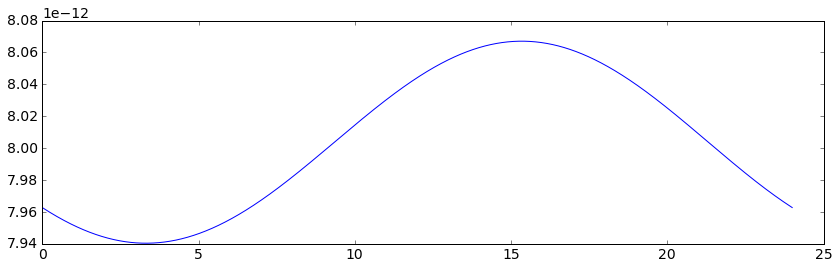

In [65]:
plt.plot(sec_array/(60*60), density_array)


In [85]:


lst_array = np.arange(0, 24, .5)
density_array = np.zeros((len(lst_array)))

for ii in range(len(lst_array)):

    
    (t, X_vector, day_of_year_init, day_of_month_init, \
                      hour_init_UT, month, year, omega_const, r_earth_const) = (27910.0, \
                ([ -1.652657172437462e+06,   5.662107446996736e+06,3.336927549329695e+06, \
                       -7.220077614566329e+03, -2.498458476334984e+03,   6.625497229082193e+02]), \
                                                175, 24, 12, 6, 2017, 7.2921158553e-05, 6378136.3)
    
    
    state = X_vector[0:3] 

    (latitude, longitude, altitude, day_of_month, hour) = \
                            filter_functions.calc_lat_lon_from_t_R(t, state, \
                                    day_of_month_init, hour_init_UT, month, year, omega_const, r_earth_const)
    
    day_of_year = math.floor(t/86400) + day_of_year_init
    t = t - math.floor(t/86400) * 86400
    
    if longitude < 0:
            longitude = longitude + 2*math.pi
    lst = filter_functions.calc_LST(hour, longitude) #lst in units of hours
    
    
    lon = 0 #dependent only on lst


    Output = nrlmsise_output()
    Input = nrlmsise_input()
    flags = nrlmsise_flags()
    aph = ap_array()

    for i in range(7):
        aph.a[i]=100
    flags.switches[0] = 1
    for i in range(1, 24):
        flags.switches[i]=1

    Input.doy = day_of_year
    Input.year = 0 #/* without effect */
    Input.sec = 0 #t*****
    Input.alt = altitude/1e3 #convert to km
    Input.g_lat = math.degrees(latitude)
    Input.g_long = math.degrees(lon)
    Input.lst = lst_array[ii]
    Input.f107A = 180 #I believe this is a "nominal" value
    Input.f107 = 180
    Input.ap = 10 

    gtd7d(Input, flags, Output)

    density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)
    
    
    density_array[ii] = density
    





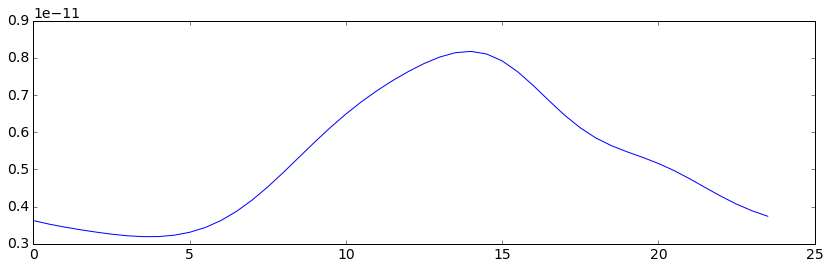

In [86]:
plt.plot(lst_array, density_array)


In [11]:

sec_array = np.linspace(0,86400, 10)
lst_array = np.arange(0, 24, .5)
density_array = np.zeros((len(lst_array), len(sec_array)))

for ii in range(len(lst_array)):
    
    
    for jj in range(len(sec_array)):

    
        (t, X_vector, day_of_year_init, day_of_month_init, \
                          hour_init_UT, month, year, omega_const, r_earth_const) = (27910.0, \
                    ([ -1.652657172437462e+06,   5.662107446996736e+06,3.336927549329695e+06, \
                           -7.220077614566329e+03, -2.498458476334984e+03,   6.625497229082193e+02]), \
                                                    175, 24, 12, 6, 2017, 7.2921158553e-05, 6378136.3)


        state = X_vector[0:3] 

        (latitude, longitude, altitude, day_of_month, hour) = \
                                filter_functions.calc_lat_lon_from_t_R(t, state, \
                                        day_of_month_init, hour_init_UT, month, year, omega_const, r_earth_const)

        day_of_year = math.floor(t/86400) + day_of_year_init
        t = t - math.floor(t/86400) * 86400

        if longitude < 0:
                longitude = longitude + 2*math.pi
        lst = filter_functions.calc_LST(hour, longitude) #lst in units of hours


        lon = 0 #dependent only on lst


        Output = nrlmsise_output()
        Input = nrlmsise_input()
        flags = nrlmsise_flags()
        aph = ap_array()

        for i in range(7):
            aph.a[i]=100
        flags.switches[0] = 1
        for i in range(1, 24):
            flags.switches[i]=1

        Input.doy = day_of_year
        Input.year = 0 #/* without effect */
        Input.sec = sec_array[jj] #t*****
        Input.alt = altitude/1e3 #convert to km
        Input.g_lat = math.degrees(latitude)
        Input.g_long = math.degrees(lon)
        Input.lst = lst_array[ii]
        Input.f107A = 180 #I believe this is a "nominal" value
        Input.f107 = 180
        Input.ap = 10 

        gtd7d(Input, flags, Output)

        density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)


        density_array[ii, jj] = density






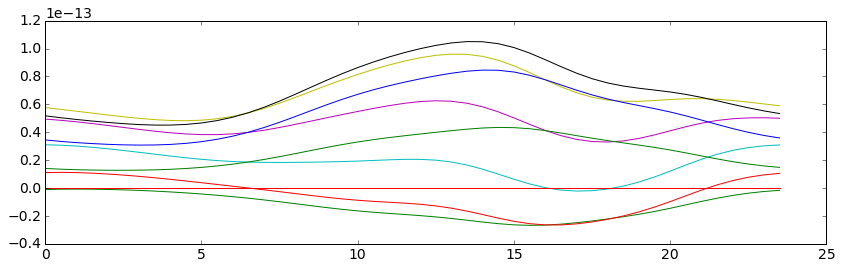

In [12]:


fig = plt.figure()

for ii in range(len(sec_array)):
    
    plt.plot(lst_array, density_array[:, ii] - density_array[:, 0])

    
plt.show()



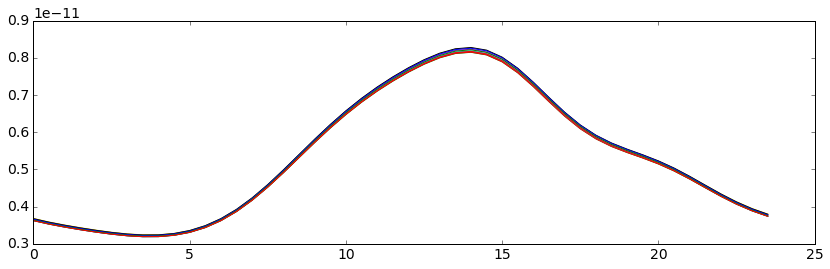

In [13]:
fig = plt.figure()

for ii in range(len(sec_array)):
    
    plt.plot(lst_array, density_array[:, ii])

    
plt.show()

In [112]:

x, y, z, J_2, J_3, r_earth, mu, r,  x_dot, y_dot, z_dot, density = \
        sym.symbols('x y z J_2 J_3 r_earth mu r,  x_dot, y_dot, z_dot, density')


x_acc = '(-mu/r**3) * x'
y_acc = '(-mu/r**3) * y'
z_acc = '(-mu/r**3) * z'

x_acc = sym.sympify(x_acc)
y_acc = sym.sympify(y_acc)
z_acc = sym.sympify(z_acc)


x_acc = x_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])
y_acc = y_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])
z_acc = z_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])



#Add drag to J_2 force equations
C_D, A, m, density, theta_dot,  = \
    sym.symbols('C_D A m density theta_dot ')


drag_str_x = ('-(1/2)*C_D*(A/m)*density*'   
        '(  ( 1/(sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)) ) *(x_dot+theta_dot*y))')

drag_str_y = ('-(1/2)*C_D*(A/m)*density*'   
        '(  ( 1/(sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)) ) *(y_dot-theta_dot*x))')

drag_str_z = ('-(1/2)*C_D*(A/m)*density*'   
        '(  ( 1/(sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)) ) *(z_dot))')


drag_symp_x = sym.sympify(drag_str_x)
drag_symp_y = sym.sympify(drag_str_y)
drag_symp_z = sym.sympify(drag_str_z)

drag_symp_x = drag_symp_x.subs([(A, A_const), (m, m_const), (C_D, C_D_est),\
                        (theta_dot, theta_dot_const)])
drag_symp_y = drag_symp_y.subs([(A, A_const), (m, m_const), (C_D, C_D_est),\
                        (theta_dot, theta_dot_const)])
drag_symp_z = drag_symp_z.subs([(A, A_const), (m, m_const), (C_D, C_D_est),\
                        (theta_dot, theta_dot_const)])




x_drag_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), drag_symp_x)




drag_symp_x = drag_symp_x.subs([(r, sym.sqrt(x**2+y**2+z**2))])
x_acc = x_acc + drag_symp_x

drag_symp_y = drag_symp_y.subs([(r, sym.sqrt(x**2+y**2+z**2))])
y_acc = y_acc + drag_symp_y

drag_symp_z = drag_symp_z.subs([(r, sym.sqrt(x**2+y**2+z**2))])
z_acc = z_acc + drag_symp_z




#print(z_acc)

x_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)




x_drag_fcn(1,2,3,4,5,6,0)
x_drag_fcn(1,2,3,4,5,6,2.70198315652e-12)